In [1]:
import pandas as pd
import json as json
from pandas import json_normalize
import os
import numpy as np
import csv
from matplotlib import pyplot as plt

import keras
import tensorflow as tf
from keras.layers import Input, Flatten, Dense, Lambda, Reshape, Dropout
from keras.layers import BatchNormalization
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.metrics import mse, accuracy
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K

keras.backend.clear_session()


srcDir = "../data/preprocessed/"
model_path = srcDir + "models/model_future/"

# Height Eval

In [2]:
fc_model = keras.models.load_model(model_path + "model")

In [3]:
# Load cleaned data
with open(srcDir + "cleaned_data_normalized.csv", 'r') as f:
    data = list(csv.reader(f))

df = pd.DataFrame(data[1:], columns=data[0])
df = df.drop(columns=["height_delta", "height_increase", "datum"])
df["container_Id"] = df["container_id"]
df.drop(columns=["container_id"], inplace=True)
data = df.values.tolist()
df.head()

,height_in_cm,temperatur_in_grad,tilt_in_grad,niederschlag_in_mm,laengengrad,breitengrad,ist_industriegebiet,ist_wohngebiet,ist_feiertag,sekunde,minute,stunde,wochentag,kalenderwoche,monat,jahr,farbe_brown,farbe_green,farbe_white,container_Id
0,0.8,0.21212122,0.0043668123,0.0,0.9998518,0.9930974,0.0,1.0,0.0,0.0,0.44067797,0.8695652,0.8333333,0.33962265,0.41666666,1.0,0.0,0.0,1.0,1.0
1,0.8,0.25757575,0.0043668123,0.0,0.9998518,0.9930974,0.0,1.0,0.0,0.084745765,0.44067797,0.82608694,0.8333333,0.33962265,0.41666666,1.0,0.0,0.0,1.0,1.0
2,0.7714286,0.22727273,0.0,0.0,0.9998518,0.9930974,0.0,1.0,0.0,1.0,0.42372882,0.7826087,0.8333333,0.33962265,0.41666666,1.0,0.0,0.0,1.0,1.0
3,0.9,0.28787878,0.0043668123,0.0,0.9998518,0.9930974,0.0,1.0,0.0,1.0,0.42372882,0.73913044,0.8333333,0.33962265,0.41666666,1.0,0.0,0.0,1.0,1.0
4,0.8428571,0.3030303,0.0,0.0,0.9998518,0.9930974,0.0,1.0,0.0,1.0,0.42372882,0.6956522,0.8333333,0.33962265,0.41666666,1.0,0.0,0.0,1.0,1.0


In [4]:
data = np.array(data[1:]).astype("float32")

In [5]:
x_test = data[:, 0]
x_test.shape

(515036,)

In [6]:
x_train = data[:, 1:]
x_train.shape

(515036, 19)

In [7]:
# 254 is max height

def prediction(index):
    data_point = np.array([x_train[index]])
    pred_height = fc_model.predict(data_point)[0][0] * 254
    real_height = x_test[index] * 254
    
    print("Real value: ", real_height, " estimated: ", pred_height)
    
def prediction_Plot(train, test, num):
    index_list = np.linspace(0, len(train)-1, num).astype("int")
    #print(index_list)
    pred_list = []
    sum_heigth = 0.0
    for x in index_list:
        data_point = np.array([train[x]])
        pred_height = fc_model.predict(data_point)[0][0] * 254
        real_height = test[x] * 254
        pred_list.append(abs(pred_height - real_height))
        sum_heigth = sum_heigth + abs(pred_height - real_height)
        
    print("Average absolute error in ", num, " data points: " , sum_heigth / num)
    plt.plot(pred_list)
    plt.ylabel('total Error')
    plt.savefig(model_path + "plots/predcition_plot.svg")
    plt.show()

In [8]:
prediction(43357)

Real value:  214.08570909500122  estimated:  211.30260014533997


Average absolute error in  1000  data points:  30.69489640473202


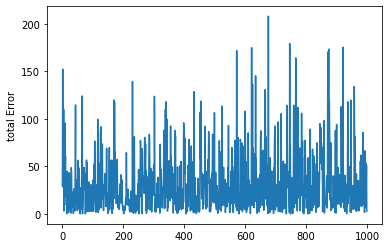

In [9]:
prediction_Plot(x_train, x_test, 1000)

In [10]:
# zeigt den geschätzten Füllhöhenverlauf
# c_id = nummer vom Container (0-77)
# size = wie viele messungen gezeigt werden sollen

def estimate_container(df, c_id, size, save):
    intrest_x = []
    intrest_y = []
    c_id = float(c_id)
    
    for x in range(len(df)):
        if df["container_Id"][x] == str(c_id):
            intrest_x.append(x_train[x])
            intrest_y.append(x_test[x])
            
            if size < len(intrest_x):
                break
            
    height = []
    estimation = []

    for x in range(len(intrest_x)):
        data_point = np.array([intrest_x[x]])
        pred_height = fc_model.predict(data_point)[0][0] * 254
        estimation.append(pred_height)
        real_height = intrest_y[x] * 254
        height.append(real_height)


    plt.plot(height)
    plt.plot(estimation)
    plt.legend(["real", "estimated"], loc="upper left")
    if save:
        plt.savefig(model_path + "plots/Container_" + str(c_id + 1) + ".svg")
        plt.close()
    else:
        plt.show()
        plt.close()

In [11]:
# für alle n = 76
#for x in range(76):
#    estimate_container(df,x,2000, True)

In [12]:
estimate_container(df,4,1000, True)